In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

from scipy.optimize import minimize
from scipy.stats import norm
import scipy.stats as ss

from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error as mse

from weights import WeightMethod
from features import FeaturesManipulation
from linear_regression import LinReg

# Adatok betöltése és formázása

### A havi munkanélküliséget válaszottam low-frequency változónak, high-frequancy változónak pedig a napi VIX index értéketi.

A low-freq változót nem használom a tesztben, csak annyi a relevanciája, hogy az alapján lesz kiválasztva valamennyi hónap. Azért változtattam GDP-ről, mert ott a negyedéves adatokkal relatíve kevés adatpontunk lenne, és ott már az a probléma is bejöhetne. Mindezek mellett meg a negyedéves adatok esetében csak 3 lag-ot kell megbecsülnie a lag függvénynek.

In [2]:
df1 = pd.read_csv('C:/Users/peter/Desktop/volatiltiy-forecasting/data/Macroeconomic/UNEMPLOY.csv')
df1['Chg'] = np.log(df1.Value).diff().fillna(0)
df1 = FeaturesManipulation.select_timeframe(df1, datetime(1990,10,1), datetime(2020,1,1))
#df1.tail()

In [3]:
df2 = pd.read_csv('C:/Users/peter/Desktop/volatiltiy-forecasting/data/Macroeconomic/VIXCLS.csv')
df2 = df2[df2.VIXCLS != '.'].reset_index(drop=True)
df2.VIXCLS = df2.VIXCLS.astype(float)
df2 = df2.rename(columns = {'DATE': 'Date'})
df2['Chg'] = np.log(df2.VIXCLS).diff().fillna(0)
#df2.head()

In [4]:
df2 = FeaturesManipulation.select_timeframe(df2, df1.Date[0], df1.Date[len(df1) -1])
#df2.tail()

A modellezésnél havi 15 laggal számolok

In [5]:
X = FeaturesManipulation.compress_data(df1, df2, 'VIXCLS', lag = 15)
display(X.tail())
X = X.values

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
2019-08,12.93,12.39,12.68,12.86,13.97,13.53,14.45,13.53,12.61,12.07,12.74,12.16,12.83,13.94,16.12
2019-09,21.09,17.52,22.10,21.18,18.47,16.88,17.50,15.80,16.68,19.87,19.32,20.31,19.35,17.88,18.98
2019-10,15.20,14.61,14.22,13.74,14.67,14.44,13.95,14.05,15.32,14.91,17.05,15.96,16.07,17.22,16.24
2019-11,15.58,14.57,13.54,13.68,13.79,14.25,14.00,14.46,14.01,13.71,12.65,13.11,13.20,12.33,13.22
2019-12,12.07,12.69,12.68,13.00,13.05,12.05,12.46,12.86,12.78,13.13,12.34,11.87,11.54,11.75,12.62


## MIDAS modell felépítése:

Egyenlőre még a modell felírása így fest. A 'midas_filter' függvényt olyan jellegűen szeretném megcsinálni a továbbiakban, mint ahogy a tensorflowba adjuk hozzá a rétegeket, tehát mondjuk a modell felírásba akarnék adni egy Béta súlyozású magyarázó változót azt valahogy így tudnám meg tenni:
<br><br>
MIDAS([<br>
    add.lagged_variable(változó, type = 'beta', lag = 15)<br>
    ...<br>
])<br>

így szerintem sokkal átláthatóbb lenne a struktúrája a modellnek. Amit beszéltünk még, hogy a 'least_squares' helyett érdemesebb lenne a 'l-bfgs-b'-t használni, ehhez a négyzetes hibák összegét kell felírni mint minimalizálandó függvényt. 

***
$\mathbf{\text{Mixed Data Sampling Model}}$<br>
***
1.&emsp;A simple model: $$y_t = \beta_0 + \beta_1  B(L^\frac{1}{m}; \theta_1; \theta_2)  x^{(m)}_t + \epsilon^{(m)}_t$$
2.&emsp;Parameter Space: $$\Theta = {(\beta_0; \beta_1; \theta_1; \theta_2)}$$
3.&emsp;Sum of Squared of Errors (SSE): $$SSE(\Theta) = \epsilon^T \epsilon = \sum {(y_t - \beta_0 -\beta_1  B(L^\frac{1}{m}; \theta_1; \theta_2)  x^{(m)}_t)}^2$$
4.&emsp;Parameter optimization: $$\underset{\Theta}{\textrm{arg min}} SSE(\Theta)$$

In [6]:
def transform(params, restrictions):
    params_trans = np.zeros(params.shape)
    for i in range(len(params)):
        if restrictions[i] == 'pos':
            params_trans[i] = np.log(params[i])
        elif restrictions[i] == '01':
            params_trans[i] = np.log(params[i]) - np.log(1 - params[i])
        else:
            params_trans[i] = params[i]
    return params_trans

def transform_back(params_trans, restrictions):
    params = np.zeros(params_trans.shape)
    for i in range(len(params_trans)):
        if restrictions[i] == 'pos':
            params[i] = np.exp(params_trans[i])
        elif restrictions[i] == '01':
            params[i] = 1 / (1 + np.exp(-params_trans[i]))
        else:
            params[i] = params_trans[i]
    return params

def midas_filter(params, X):
    model = params[0] + params[1] * WeightMethod().x_weighted_beta(X, params[2:])
    return model

def midas_SSE(params, y, x):
    return sum((y - midas_filter(params, x))**2)

def midas_SSE_trans(params_trans, y, x, restrictions):
    params = transform_back(params_trans, restrictions)
    return midas_SSE(params, y, x)

def midas_fit(init_params, y, x, restrictions, bounds = None):
    if bounds == None:
        res = minimize(midas_SSE_trans, init_params, 
                       args = (y, x, restrictions),
                       options = {'disp': True}, 
                       method = 'l-bfgs-b')
    else:
        res = minimize(midas_SSE_trans, init_params, 
                       args = (y, x, restrictions),
                       bounds = bounds,
                       options = {'disp': True}, 
                       method = 'l-bfgs-b')
    return res

A véletlenre megadtam a random.seed(14)-et. Először megcsináltam a tiszta modellt, amibe nincs semmi zaj. A zajt egy N(0, 1) sztenderd normális véletlen szám biztosítja, amit hozzáadva a tiszta modellhez lett a 'y_hat' változó. Itt a zaj szórásával lehet játszadozni. A tapasztalat az, hogy minél több zajt vittem bele, annél rosszabbul tudta becsülni a Theta paramétereket. Akkor a Thetákra olyasmi jött ki, hogy az első lag relatíve magas súllyal jelenik meg a többi viszont közel azonosan. Talán erre egy jó megoldás lehetne, hogy lefixáljuk a Theta1 paramétert 1-nek és akkor innentől kezdve egy monoton csökkenő függvényt kapunk.

In [30]:
np.random.seed(14)

estimate = midas_filter([0., 1., 1., 4.], X)

eps = np.random.normal(0, 5, estimate.shape[0])
y_hat = estimate + eps

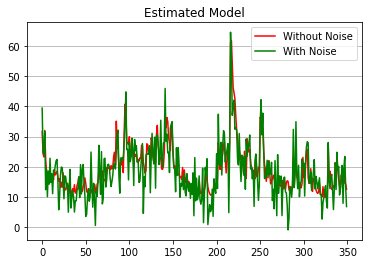

In [31]:
plt.plot(estimate, 'r', label = 'Without Noise')
plt.plot(y_hat, 'g', label = 'With Noise')
plt.title('Estimated Model')
plt.legend(loc = 'best')
plt.grid(axis = 'y')
plt.show()

## Modell becslése:
Megadtam a következő kezdeti paramétereket:
Beta0  = 1
Beta1  = 1
Theta1 = 1
Theta2 = 1

Ezekkel lefutattam az optimalizálást, aminek az eredményeit ki is írattam. Az output-ban is olvasható, hogy sikeres lett az optimalizálás és a becsült paraméterek is. Azokat kiírattam, hogy jobban lássuk melyik paraméterhez milyen értéket becsült.

In [32]:
init_params = np.array([1, 1, 1, 1])
restrictions = np.array(['pos', 'pos', 'pos', 'pos'])
init_params_trans = transform(init_params, restrictions)

midas_out = midas_fit(init_params_trans, y_hat, X, restrictions)
midas_out

      fun: 9480.429045491628
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.0001819 ,  0.04165486,  0.01109584, -0.00254659])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 170
      nit: 31
     njev: 34
   status: 0
  success: True
        x: array([-1.56838411, -0.04965189, -0.06350567,  0.43829592])

In [33]:
params_opt = transform_back(midas_out.x, restrictions)

In [34]:
params_opt

array([0.20838163, 0.95156062, 0.9384688 , 1.55006353])

## Lag függvények:
Készítettem egy ábrát is, ahol láthatjuk a modell által becsült paraméterek milyen lag függvényt adnak ki (piros), és hogy fest az 'elméleti' lag függvényünk (zöld)

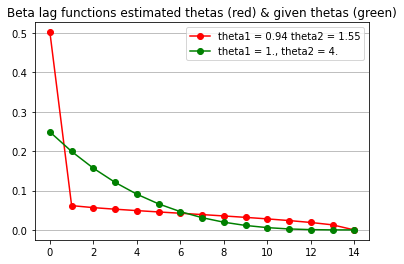

In [35]:
model_beta = WeightMethod().BetaWeights([params_opt[2], params_opt[3]], 15)

plt.plot(model_beta, 'ro-', label = 'theta1 = '+ str(round(params_opt[2],2)) + ' theta2 = ' + str(round(params_opt[3],2)))
plt.plot(WeightMethod().BetaWeights([1., 4.], 15), 'go-', label = 'theta1 = 1., theta2 = 4.')
plt.title('Beta lag functions estimated thetas (red) & given thetas (green)')
plt.legend(loc = 'best')
plt.grid(axis = 'y')
plt.show()

## Becsült Paraméterek:

In [36]:
var = midas_out.hess_inv.todense()/len(df2)
upper = params_opt + ss.norm.ppf(1.0 - 0.05 / 2.0)*np.multiply(np.sqrt(np.diagonal(var)), params_opt)
lower = params_opt - ss.norm.ppf(1.0 - 0.05 / 2.0)* np.multiply(np.sqrt(np.diagonal(var)), params_opt)
se = np.round(np.diag(var), 4)
print('Parameter   Estimate       Std. Err.     95% CI lower     95% CI upper')
params = ['Beta0', 'Beta1', 'Theta1', 'Theta2']
for i in range(len(se)):
    print('{0:<11} {1:>0.6f}        {2:0.6f}        {3: 0.5f}        {4:0.6f}'.format(params[i], params_opt[i], se[i], lower[i], upper[i]))

Parameter   Estimate       Std. Err.     95% CI lower     95% CI upper
Beta0       0.208382        0.196900         0.02717        0.389590
Beta1       0.951561        0.000000         0.94153        0.961593
Theta1      0.938469        0.000000         0.93407        0.942871
Theta2      1.550064        0.002200         1.40697        1.693158


## Becslés Pontosságára szolgáló mutatók:

In [37]:
fit1 = midas_filter(params_opt, X)
print('R2 score of this model: ', round(r2(y_hat, fit1), 6))
print('MSE of this model: ', round(mse(y_hat, fit1), 6))
print('Mean Absolute Deviation (MAD) of this model: ', round(np.mean(np.absolute(fit1 - np.mean(fit1))), 6))

R2 score of this model:  0.655536
MSE of this model:  27.08694
Mean Absolute Deviation (MAD) of this model:  5.289326
